## Bayesian Optimization w/ Interpolated Samples
In some situations, the process of evaluating objectives and constraints
consumes fewer resources compared to the computational demands associated
with Bayesian Optimization (BO) decision-making. Particularly, when
making subtle changes to parameters during optimization, the cost of
assessing objectives becomes notably more affordable.

Consider a practical example: the optimization of magnet parameters in an
accelerator with the goal of either minimizing the beam spot size on a
screen or maximizing the Free Electron Laser (FEL) pulse energy. In such
cases, where adjustments to accelerator parameters are frequent, it proves
beneficial to augment the dataset by implementing multiple smaller changes
to the parameters. These adjustments are followed by quick measurements of
the objective in between the parameter changes guided by BO.

This approach, although introducing a slight slowdown to the BO process
due to the addition of extra training points, it will expedite
convergence for most problems. It offers a more efficient alternative compared to the
strategy of measuring the same points multiple times in noisy environments.
The rationale here is that the exploration of a broader parameter space
through numerous smaller changes enhances the overall understanding of
the system's behavior, potentially leading to a more efficient and
effective optimization process.

NOTE: This only works for serialized problems.

WARNING: The interpolated points may violate constraints! Do not use this feature in
problems where safety is critical.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sphere
 function.

In [1]:
from xopt.vocs import VOCS

# define variables and function objectives
vocs = VOCS(
    variables={"x1": [-1, 1], "x2": [-1, 1]},
    objectives={"f": "MINIMIZE"},
)

In [2]:
# define a test function to optimize

def sphere_function(input_dict):
    return {"f": input_dict["x1"]**2 + input_dict["x2"]**2}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acquisition function to perform Bayesian Optimization. We
additionally specify `n_interpolate_points` to be non-zero such that the generator
proposes interpolated points during generation.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt

# define a generator that uses 5 interpolation points during sampling
generator = ExpectedImprovementGenerator(vocs=vocs, n_interpolate_points=5)
generator.gp_constructor.use_low_noise_prior = True


evaluator = Evaluator(function=sphere_function)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# call X.random_evaluate() to generate + evaluate initial points
X.random_evaluate(2)

# inspect the gathered data
X.data

x1        x2         f  xopt_runtime  xopt_error
0  0.245077  0.436568  0.250654      0.000004       False
1  0.178836  0.668327  0.478643      0.000001       False

## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

0


1


2


3


4


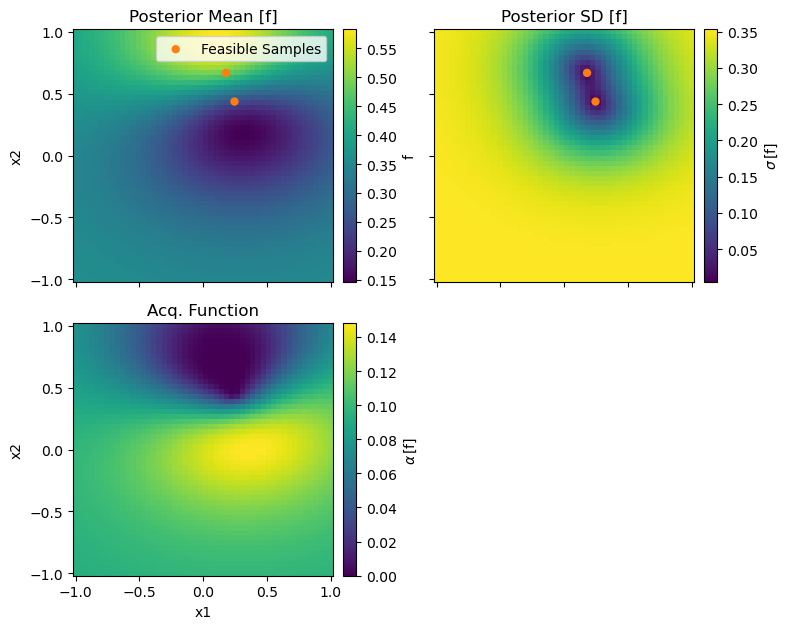

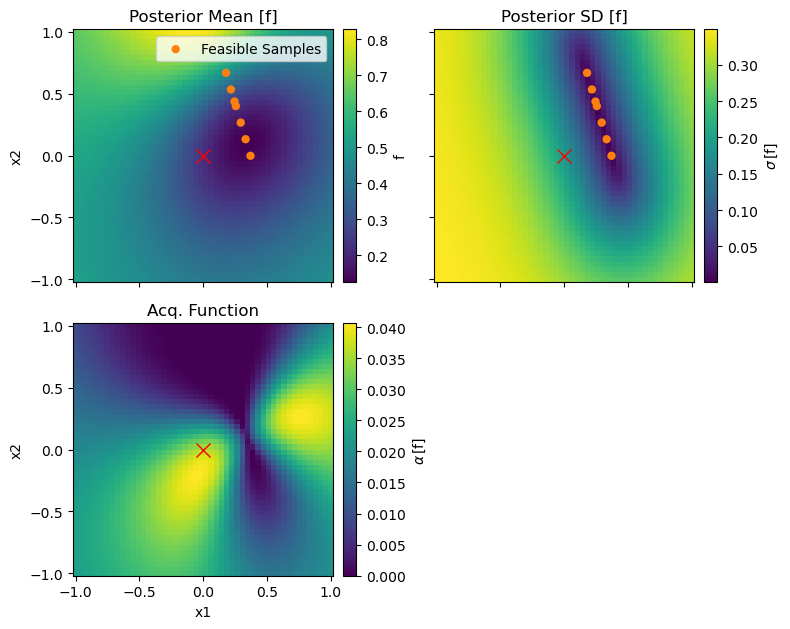

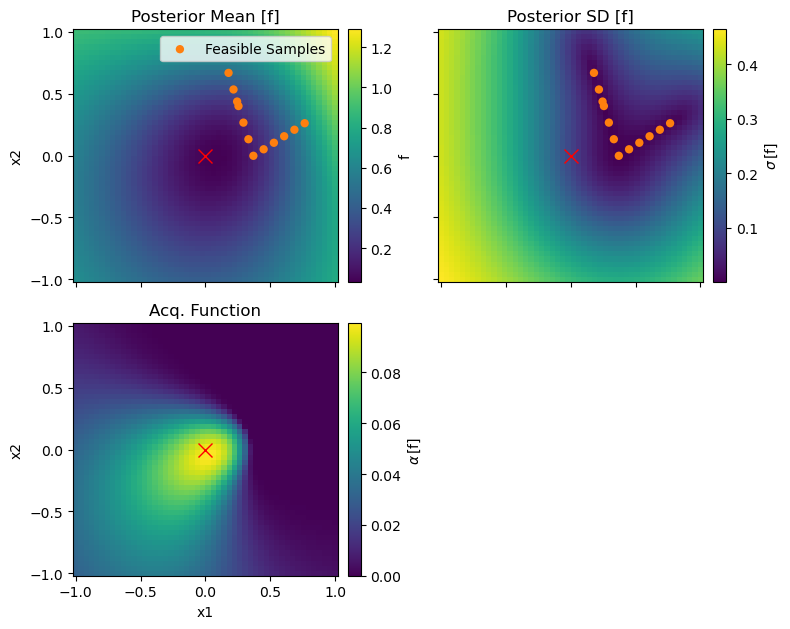

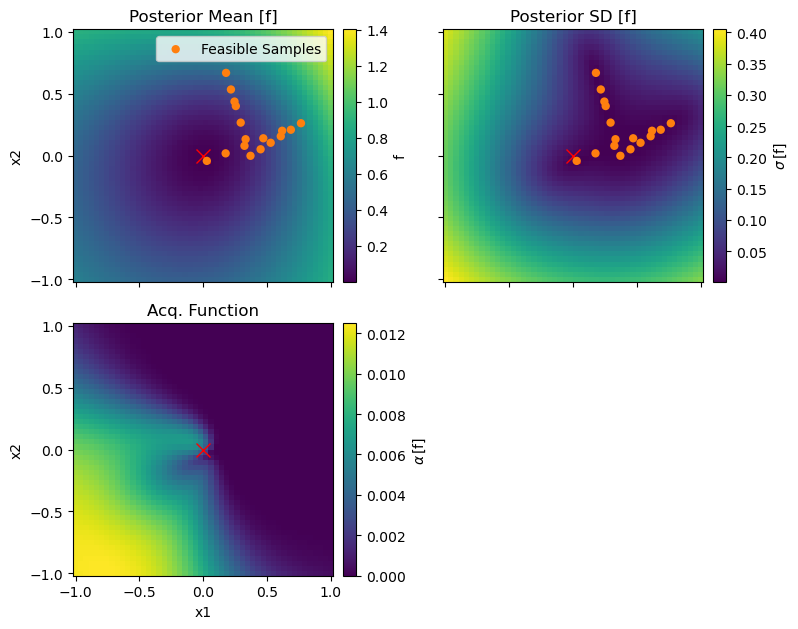

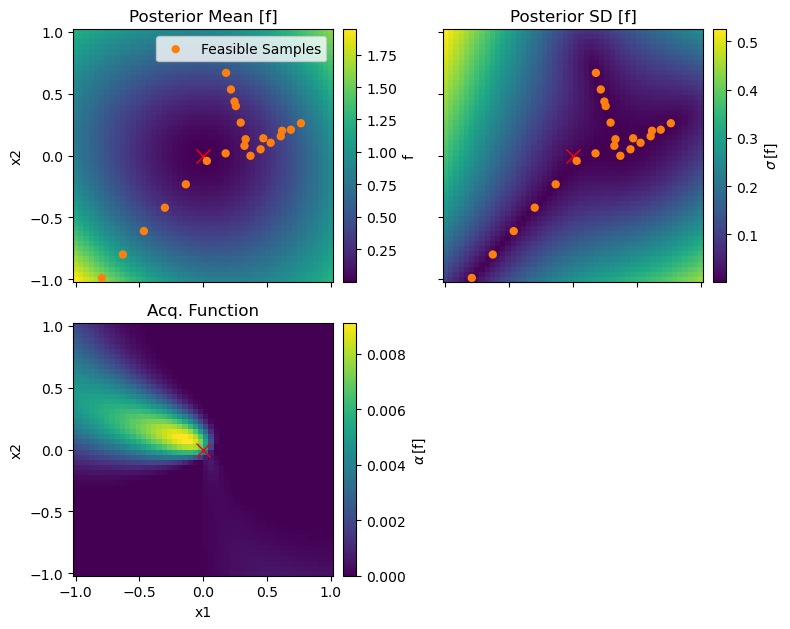

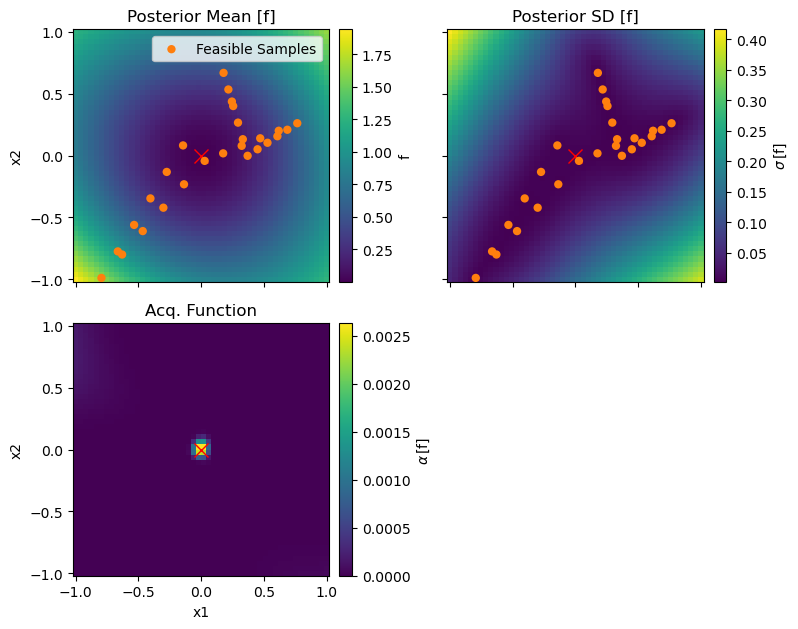

In [5]:
X.generator.train_model()
X.generator.visualize_model(n_grid=50)

n_steps = 5
for i in range(n_steps):
    print(i)
    # do the optimization step
    X.step()

    # train the model and visualize
    X.generator.train_model()
    fig,ax = X.generator.visualize_model(n_grid=50)

    # add the ground truth minimum location
    for a in ax.flatten()[:-1]:
        a.plot(0,0,"x",c="red",ms=10)


In [6]:
# access the collected data
X.data

x1        x2         f  xopt_runtime  xopt_error
0   0.245077  0.436568  0.250654  3.506000e-06       False
1   0.178836  0.668327  0.478643  1.242000e-06       False
2   0.217162  0.534237  0.332568  3.747000e-06       False
3   0.255488  0.400146  0.225391  1.092000e-06       False
4   0.293814  0.266056  0.157112  7.210000e-07       False
5   0.332140  0.131965  0.127732  9.320000e-07       False
6   0.370466 -0.002125  0.137249  1.082000e-06       False
7   0.449572  0.050547  0.204670  3.557000e-06       False
8   0.528678  0.103218  0.290154  9.710001e-07       False
9   0.607784  0.155890  0.393703  8.009999e-07       False
10  0.686889  0.208562  0.515315  9.820000e-07       False
11  0.765995  0.261234  0.654992  7.210000e-07       False
12  0.618410  0.200337  0.422566  3.847000e-06       False
13  0.470824  0.139441  0.241119  1.432000e-06       False
14  0.323239  0.078544  0.110653  8.820000e-07       False
15  0.175654  0.017647  0.031166  7.610000e-07       False
16  0.028068 -0.043249  0.002658  1.142000e-06       False
17 -0.136313 -0.232506  0.072640  3.897000e-06       False
18 -0.300694 -0.421764  0.268301  1.152000e-06       False
19 -0.465074 -0.611021  0.589641  5.910000e-07       False
20 -0.629455 -0.800278  1.036659  1.253000e-06       False
21 -0.793836 -0.989535  1.609355  7.919999e-07       False
22 -0.663843 -0.775284  1.041752  4.579000e-06       False
23 -0.533849 -0.561032  0.599752  1.423000e-06       False
24 -0.403856 -0.346781  0.283357  8.720000e-07       False
25 -0.273863 -0.132529  0.092565  6.710001e-07       False
26 -0.143869  0.081722  0.027377  1.052000e-06       False

## Getting the optimization result
To get the best point (without evaluating it) we ask the generator to
predict the optimum based on the posterior mean.

In [7]:
X.generator.get_optimum()

x1        x2
0  0.001555 -0.000187